# ECE C147/247 HW4 Q3: Dropout

In this notebook, you will implement dropout.  Then we will ask you to train a network with batchnorm and dropout, and acheive over 55% accuracy on CIFAR-10.

`utils` has built a solid API for building these modular frameworks and training them, and we will use their very well implemented framework as opposed to "reinventing the wheel."  This includes using their Solver, various utility functions, and their layer structure.  This also includes `nndl.fc_net`, `nndl.layers`, and `nndl.layer_utils`.

In [1]:
## Import and setups

import time
import numpy as np
import matplotlib.pyplot as plt
from nndl.fc_net import *
from nndl.layers import *
from utils.data_utils import get_CIFAR10_data
from utils.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from utils.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k in data.keys():
  print('{}: {} '.format(k, data[k].shape))

X_train: (49000, 3, 32, 32) 
y_train: (49000,) 
X_val: (1000, 3, 32, 32) 
y_val: (1000,) 
X_test: (1000, 3, 32, 32) 
y_test: (1000,) 


## Dropout forward pass

Implement the training and test time dropout forward pass, `dropout_forward`, in `nndl/layers.py`. After that, test your implementation by running the following cell.

In [3]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())

Running tests with p =  0.3
Mean of input:  9.99685010214567
Mean of train-time output:  9.973354144793436
Mean of test-time output:  9.99685010214567
Fraction of train-time output set to zero:  0.301636
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.6
Mean of input:  9.99685010214567
Mean of train-time output:  9.995998684721517
Mean of test-time output:  9.99685010214567
Fraction of train-time output set to zero:  0.599936
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.75
Mean of input:  9.99685010214567
Mean of train-time output:  10.00209523824298
Mean of test-time output:  9.99685010214567
Fraction of train-time output set to zero:  0.749776
Fraction of test-time output set to zero:  0.0


## Dropout backward pass

Implement the backward pass, `dropout_backward`, in `nndl/layers.py`.  After that, test your gradients by running the following cell:

In [4]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  1.892906988930252e-11


## Implement a fully connected neural network with dropout layers

Modify the `FullyConnectedNet()` class in `nndl/fc_net.py` to incorporate dropout.  A dropout layer should be incorporated after every ReLU layer.  Concretely, there shouldn't be a dropout at the output layer since there is no ReLU at the output layer. You will need to modify the class in the following areas:

(1) In the forward pass, you will need to incorporate a dropout layer after every relu layer.

(2) In the backward pass, you will need to incorporate a dropout backward pass layer.

Check your implementation by running the following code.  Our W1 gradient relative error is on the order of 1e-6 (the largest of all the relative errors).

In [5]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('{} relative error: {}'.format(name, rel_error(grad_num, grads[name])))
  print('\n')

Running check with dropout =  0
Initial loss:  2.3051948273987857
W1 relative error: 2.5272575382129597e-07
W2 relative error: 1.5034484922161239e-05
W3 relative error: 2.7534468139587135e-07
b1 relative error: 2.936957506391204e-06
b2 relative error: 5.0513393785120424e-08
b3 relative error: 1.1740467838205477e-10


Running check with dropout =  0.25
Initial loss:  2.3052077546540826
W1 relative error: 2.6138469533439284e-07
W2 relative error: 5.022056554497157e-07
W3 relative error: 4.4563160427353564e-08
b1 relative error: 7.397117495005868e-08
b2 relative error: 7.151679404650099e-10
b3 relative error: 1.003974732116764e-10


Running check with dropout =  0.5
Initial loss:  2.3035667586595423
W1 relative error: 1.1401257489261862e-06
W2 relative error: 1.847669394519882e-07
W3 relative error: 6.5966195253431734e-09
b1 relative error: 7.716395914021063e-08
b2 relative error: 1.1975910493629166e-09
b3 relative error: 1.4558471033827801e-10




## Dropout as a regularizer

In class, we claimed that dropout acts as a regularizer by effectively bagging.  To check this, we will train two small networks, one with dropout and one without dropout.  

In [6]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.6]
for dropout in dropout_choices:
  model = FullyConnectedNet([100, 100, 100], dropout=dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

(Iteration 1 / 125) loss: 2.300804
(Epoch 0 / 25) train acc: 0.220000; val_acc: 0.168000
(Epoch 1 / 25) train acc: 0.188000; val_acc: 0.147000
(Epoch 2 / 25) train acc: 0.266000; val_acc: 0.200000
(Epoch 3 / 25) train acc: 0.338000; val_acc: 0.262000
(Epoch 4 / 25) train acc: 0.378000; val_acc: 0.278000
(Epoch 5 / 25) train acc: 0.428000; val_acc: 0.297000
(Epoch 6 / 25) train acc: 0.468000; val_acc: 0.323000
(Epoch 7 / 25) train acc: 0.494000; val_acc: 0.287000
(Epoch 8 / 25) train acc: 0.566000; val_acc: 0.328000
(Epoch 9 / 25) train acc: 0.572000; val_acc: 0.322000
(Epoch 10 / 25) train acc: 0.622000; val_acc: 0.324000
(Epoch 11 / 25) train acc: 0.670000; val_acc: 0.279000
(Epoch 12 / 25) train acc: 0.710000; val_acc: 0.338000
(Epoch 13 / 25) train acc: 0.746000; val_acc: 0.319000
(Epoch 14 / 25) train acc: 0.792000; val_acc: 0.307000
(Epoch 15 / 25) train acc: 0.834000; val_acc: 0.297000
(Epoch 16 / 25) train acc: 0.876000; val_acc: 0.327000
(Epoch 17 / 25) train acc: 0.886000; val

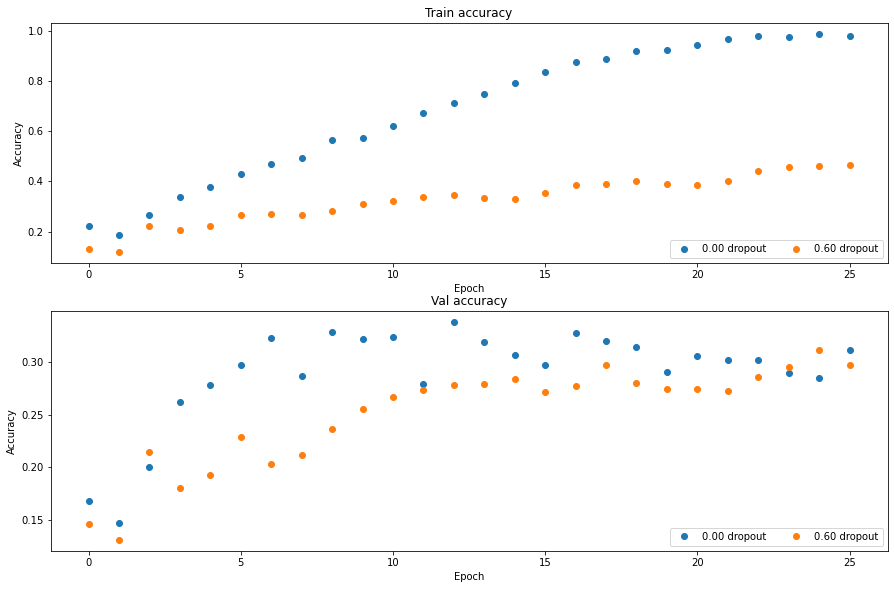

In [7]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Question

Based off the results of this experiment, is dropout performing regularization?  Explain your answer.

## Answer:

Yes, the dropout layer does perform regularization. Although the model with and without dropout have similar validation accuracies, the model without dropout (blue) has significantly higher training accury compared to the model with dropout (orange). This means that the additional training accuracy the model without dropout has is overfitting and the model with dropout, in fact, regularize it. Also, droput can be thought of regularizing each hidden unit to work well in many different contexts.

## Final part of the assignment

Get over 55% validation accuracy on CIFAR-10 by using the layers you have implemented.  You will be graded according to the following equation:

`min(floor((X - 32%)) / 28%, 1)` 

where if you get 60% or higher validation accuracy, you get full points.

In [9]:
# ================================================================ #
# YOUR CODE HERE:
#   Implement a FC-net that achieves at least 55% validation accuracy
#   on CIFAR-10.
# ================================================================ #

hidden_dims = [600, 600, 600, 600]
learning_rate = 2e-3
weight_scale = 0.01
lr_decay = 0.95
dropout = 0.55
update_rule = 'adam'

# create FullyConnectedNet
model = FullyConnectedNet(hidden_dims=hidden_dims, weight_scale=weight_scale, 
                          dropout=dropout, use_batchnorm=True, reg=0.0)

# solve 
solver = Solver(model, data,
              num_epochs=100, batch_size=100,
              update_rule=update_rule,
              optim_config={
                'learning_rate': learning_rate,
              },
              lr_decay=lr_decay,
              verbose=True, print_every=100)
solver.train()

# print out the validation accuracy
y_test_pred = np.argmax(model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(model.loss(data['X_val']), axis=1)
print('Validation set accuracy: {}'.format(np.mean(y_val_pred == data['y_val'])))
print('Test set accuracy: {}'.format(np.mean(y_test_pred == data['y_test'])))


# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

(Iteration 1 / 49000) loss: 2.368804
(Epoch 0 / 100) train acc: 0.185000; val_acc: 0.167000
(Iteration 101 / 49000) loss: 1.862784
(Iteration 201 / 49000) loss: 1.807049
(Iteration 301 / 49000) loss: 1.745462
(Iteration 401 / 49000) loss: 1.755246
(Epoch 1 / 100) train acc: 0.418000; val_acc: 0.438000
(Iteration 501 / 49000) loss: 1.707795
(Iteration 601 / 49000) loss: 1.741667
(Iteration 701 / 49000) loss: 1.721698
(Iteration 801 / 49000) loss: 1.446650
(Iteration 901 / 49000) loss: 1.553775
(Epoch 2 / 100) train acc: 0.490000; val_acc: 0.458000
(Iteration 1001 / 49000) loss: 1.891812
(Iteration 1101 / 49000) loss: 1.525608
(Iteration 1201 / 49000) loss: 1.562973
(Iteration 1301 / 49000) loss: 1.481514
(Iteration 1401 / 49000) loss: 1.561436
(Epoch 3 / 100) train acc: 0.507000; val_acc: 0.488000
(Iteration 1501 / 49000) loss: 1.469753
(Iteration 1601 / 49000) loss: 1.493207
(Iteration 1701 / 49000) loss: 1.414905
(Iteration 1801 / 49000) loss: 1.325406
(Iteration 1901 / 49000) loss: 1

(Iteration 15801 / 49000) loss: 1.041394
(Iteration 15901 / 49000) loss: 1.104018
(Iteration 16001 / 49000) loss: 0.926311
(Iteration 16101 / 49000) loss: 1.168481
(Epoch 33 / 100) train acc: 0.712000; val_acc: 0.575000
(Iteration 16201 / 49000) loss: 0.964470
(Iteration 16301 / 49000) loss: 1.182668
(Iteration 16401 / 49000) loss: 0.995676
(Iteration 16501 / 49000) loss: 1.102167
(Iteration 16601 / 49000) loss: 1.113402
(Epoch 34 / 100) train acc: 0.733000; val_acc: 0.574000
(Iteration 16701 / 49000) loss: 0.987856
(Iteration 16801 / 49000) loss: 1.012500
(Iteration 16901 / 49000) loss: 1.235728
(Iteration 17001 / 49000) loss: 1.072272
(Iteration 17101 / 49000) loss: 0.979338
(Epoch 35 / 100) train acc: 0.715000; val_acc: 0.578000
(Iteration 17201 / 49000) loss: 0.875236
(Iteration 17301 / 49000) loss: 1.016472
(Iteration 17401 / 49000) loss: 1.102627
(Iteration 17501 / 49000) loss: 1.117850
(Iteration 17601 / 49000) loss: 1.139715
(Epoch 36 / 100) train acc: 0.702000; val_acc: 0.5690

(Iteration 31501 / 49000) loss: 0.977298
(Iteration 31601 / 49000) loss: 0.886769
(Iteration 31701 / 49000) loss: 0.706246
(Iteration 31801 / 49000) loss: 0.938222
(Epoch 65 / 100) train acc: 0.777000; val_acc: 0.591000
(Iteration 31901 / 49000) loss: 0.966905
(Iteration 32001 / 49000) loss: 0.698999
(Iteration 32101 / 49000) loss: 1.005880
(Iteration 32201 / 49000) loss: 1.076777
(Iteration 32301 / 49000) loss: 1.008022
(Epoch 66 / 100) train acc: 0.753000; val_acc: 0.587000
(Iteration 32401 / 49000) loss: 0.936593
(Iteration 32501 / 49000) loss: 1.028871
(Iteration 32601 / 49000) loss: 1.259206
(Iteration 32701 / 49000) loss: 0.924877
(Iteration 32801 / 49000) loss: 0.997265
(Epoch 67 / 100) train acc: 0.773000; val_acc: 0.589000
(Iteration 32901 / 49000) loss: 0.916587
(Iteration 33001 / 49000) loss: 0.820689
(Iteration 33101 / 49000) loss: 0.916362
(Iteration 33201 / 49000) loss: 1.008112
(Iteration 33301 / 49000) loss: 0.876682
(Epoch 68 / 100) train acc: 0.771000; val_acc: 0.5850

(Iteration 47201 / 49000) loss: 0.994337
(Iteration 47301 / 49000) loss: 0.874650
(Iteration 47401 / 49000) loss: 1.115838
(Iteration 47501 / 49000) loss: 1.052833
(Epoch 97 / 100) train acc: 0.789000; val_acc: 0.585000
(Iteration 47601 / 49000) loss: 0.975527
(Iteration 47701 / 49000) loss: 0.793176
(Iteration 47801 / 49000) loss: 0.825106
(Iteration 47901 / 49000) loss: 0.962648
(Iteration 48001 / 49000) loss: 0.912906
(Epoch 98 / 100) train acc: 0.774000; val_acc: 0.584000
(Iteration 48101 / 49000) loss: 0.832927
(Iteration 48201 / 49000) loss: 0.967818
(Iteration 48301 / 49000) loss: 0.812962
(Iteration 48401 / 49000) loss: 0.723271
(Iteration 48501 / 49000) loss: 0.881264
(Epoch 99 / 100) train acc: 0.779000; val_acc: 0.586000
(Iteration 48601 / 49000) loss: 0.889207
(Iteration 48701 / 49000) loss: 0.922376
(Iteration 48801 / 49000) loss: 0.958328
(Iteration 48901 / 49000) loss: 0.827294
(Epoch 100 / 100) train acc: 0.781000; val_acc: 0.584000
Validation set accuracy: 0.591
Test s

In [ ]:
import numpy as np


def affine_forward(x, w, b):
  """
  Computes the forward pass for an affine (fully-connected) layer.

  The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
  examples, where each example x[i] has shape (d_1, ..., d_k). We will
  reshape each input into a vector of dimension D = d_1 * ... * d_k, and
  then transform it to an output vector of dimension M.

  Inputs:
  - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
  - w: A numpy array of weights, of shape (D, M)
  - b: A numpy array of biases, of shape (M,)
  
  Returns a tuple of:
  - out: output, of shape (N, M)
  - cache: (x, w, b)
  """

  # ================================================================ #
  # YOUR CODE HERE:
  #   Calculate the output of the forward pass.  Notice the dimensions
  #   of w are D x M, which is the transpose of what we did in earlier 
  #   assignments.
  # ================================================================ #


  
  x_res = x.reshape((x.shape[0], w.shape[0])) # Shape of N * D
  out = x_res.dot(w) + b.reshape((1, b.shape[0])) # Shape of N * M


  # ================================================================ #
  # END YOUR CODE HERE
  # ================================================================ #
    
  cache = (x, w, b)
  return out, cache


def affine_backward(dout, cache):
  """
  Computes the backward pass for an affine layer.

  Inputs:
  - dout: Upstream derivative, of shape (N, M)
  - cache: Tuple of:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

  Returns a tuple of:
  - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
  - dw: Gradient with respect to w, of shape (D, M)
  - db: Gradient with respect to b, of shape (M,)
  """
  x, w, b = cache
  dx, dw, db = None, None, None

  # ================================================================ #
  # YOUR CODE HERE:
  #   Calculate the gradients for the backward pass.
  # Notice:  
  #   dout is N x M
  #   dx should be N x d1 x ... x dk; it relates to dout through multiplication with w, which is D x M
  #   dw should be D x M; it relates to dout through multiplication with x, which is N x D after reshaping
  #   db should be M; it is just the sum over dout examples
  # ================================================================ #

    
  x_res = np.reshape(x, (x.shape[0], w.shape[0]))
  dx_res = dout.dot(w.T)
  dx = np.reshape(dx_res, x.shape) # Shape of N * D
  dw = x_res.T.dot(dout) # Shape of D * M
  db = dout.T.dot(np.ones(x.shape[0]))  # Shape of M * 1


  # ================================================================ #
  # END YOUR CODE HERE
  # ================================================================ #
  
  return dx, dw, db

def relu_forward(x):
  """
  Computes the forward pass for a layer of rectified linear units (ReLUs).

  Input:
  - x: Inputs, of any shape

  Returns a tuple of:
  - out: Output, of the same shape as x
  - cache: x
  """
  # ================================================================ #
  # YOUR CODE HERE:
  #   Implement the ReLU forward pass.
  # ================================================================ #
  
  out = np.maximum(0, x)

  # ================================================================ #
  # END YOUR CODE HERE
  # ================================================================ #
 
  cache = x
  return out, cache


def relu_backward(dout, cache):
  """
  Computes the backward pass for a layer of rectified linear units (ReLUs).

  Input:
  - dout: Upstream derivatives, of any shape
  - cache: Input x, of same shape as dout

  Returns:
  - dx: Gradient with respect to x
  """
  x = cache

  # ================================================================ #
  # YOUR CODE HERE:
  #   Implement the ReLU backward pass
  # ================================================================ #

  dx = (x > 0) * (dout)


  # ================================================================ #
  # END YOUR CODE HERE
  # ================================================================ #
 
  return dx

def batchnorm_forward(x, gamma, beta, bn_param):
  """
  Forward pass for batch normalization.
  
  During training the sample mean and (uncorrected) sample variance are
  computed from minibatch statistics and used to normalize the incoming data.
  During training we also keep an exponentially decaying running mean of the mean
  and variance of each feature, and these averages are used to normalize data
  at test-time.

  At each timestep we update the running averages for mean and variance using
  an exponential decay based on the momentum parameter:

  running_mean = momentum * running_mean + (1 - momentum) * sample_mean
  running_var = momentum * running_var + (1 - momentum) * sample_var

  Note that the batch normalization paper suggests a different test-time
  behavior: they compute sample mean and variance for each feature using a
  large number of training images rather than using a running average. For
  this implementation we have chosen to use running averages instead since
  they do not require an additional estimation step; the torch7 implementation
  of batch normalization also uses running averages.

  Input:
  - x: Data of shape (N, D)
  - gamma: Scale parameter of shape (D,)
  - beta: Shift paremeter of shape (D,)
  - bn_param: Dictionary with the following keys:
    - mode: 'train' or 'test'; required
    - eps: Constant for numeric stability
    - momentum: Constant for running mean / variance.
    - running_mean: Array of shape (D,) giving running mean of features
    - running_var Array of shape (D,) giving running variance of features

  Returns a tuple of:
  - out: of shape (N, D)
  - cache: A tuple of values needed in the backward pass
  """
  mode = bn_param['mode']
  eps = bn_param.get('eps', 1e-5)
  momentum = bn_param.get('momentum', 0.9)

  N, D = x.shape
  running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
  running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

  out, cache = None, None
  if mode == 'train':
    
    # ================================================================ #
    # YOUR CODE HERE:
    #   A few steps here:
    #     (1) Calculate the running mean and variance of the minibatch.
    #     (2) Normalize the activations with the running mean and variance.
    #     (3) Scale and shift the normalized activations.  Store this
    #         as the variable 'out'
    #     (4) Store any variables you may need for the backward pass in
    #         the 'cache' variable.
    # ================================================================ #

   mean_minibatch = np.mean(x, axis=0)
   var_minibatch  = np.var(x, axis=0)
   x_normalize = (x - mean_minibatch) / np.sqrt(var_minibatch + eps)
   out = gamma * x_normalize + beta
   
   mean_running = running_mean 
   var_running  = running_var  

   mean_running = momentum * mean_running + (1 - momentum) * mean_minibatch
   var_running  = momentum * var_running + (1 - momentum) * var_minibatch
   bn_param['running_mean'] = mean_running
   bn_param['running_var'] = var_running

   cache = {
      'minibatch_var': var_minibatch,
      'x_centralize': (x - mean_minibatch),
      'x_normalize': x_normalize,
      'gamma': gamma,
      'eps': eps
    }


    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
  
  elif mode == 'test':
        
        

        
    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the testing time normalized activation.  Normalize using
    #   the running mean and variance, and then scale and shift appropriately.
    #   Store the output as 'out'.
    # ================================================================ #
    out = gamma * (x - running_mean) / np.sqrt(running_var + eps) + beta
    
 
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
  else:
    raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

  # Store the updated running means back into bn_param
  bn_param['running_mean'] = running_mean
  bn_param['running_var'] = running_var

  return out, cache

def batchnorm_backward(dout, cache):
  """
  Backward pass for batch normalization.
  
  For this implementation, you should write out a computation graph for
  batch normalization on paper and propagate gradients backward through
  intermediate nodes.
  
  Inputs:
  - dout: Upstream derivatives, of shape (N, D)
  - cache: Variable of intermediates from batchnorm_forward.
  
  Returns a tuple of:
  - dx: Gradient with respect to inputs x, of shape (N, D)
  - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
  - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
  """
  dx, dgamma, dbeta = None, None, None

  # ================================================================ #
  # YOUR CODE HERE:
  #   Implement the batchnorm backward pass, calculating dx, dgamma, and dbeta.
  # ================================================================ #
    
  N = dout.shape[0]
  minibatch_var = cache.get('minibatch_var')
  x_centralize = cache.get('x_centralize')
  x_normalize = cache.get('x_normalize')
  gamma = cache.get('gamma')
  eps = cache.get('eps')
  
  # calculate dx
  dxhat = dout * gamma
  dxmu1 = dxhat / np.sqrt(minibatch_var + eps)
  sqrt_var = np.sqrt(minibatch_var + eps)
  dsqrt_var = -np.sum(dxhat * x_centralize, axis=0) / (sqrt_var**2)
  dvar = dsqrt_var * 0.5 / sqrt_var
  dxmu2 = 2 * x_centralize * dvar * np.ones_like(dout) / N
  dx1 = dxmu1 + dxmu2
  dx2 = -np.sum(dx1, axis=0) * np.ones_like(dout) / N
  dx = dx1 + dx2
  
  # calculate dbeta and dgamma
  dbeta = np.sum(dout, axis=0)
  dgamma = np.sum(dout * x_normalize, axis=0)
  # ================================================================ #
  # END YOUR CODE HERE
  # ================================================================ #
  
  return dx, dgamma, dbeta

def dropout_forward(x, dropout_param):
  """
  Performs the forward pass for (inverted) dropout.

  Inputs:
  - x: Input data, of any shape
  - dropout_param: A dictionary with the following keys:
    - p: Dropout parameter. We drop each neuron output with probability p.
    - mode: 'test' or 'train'. If the mode is train, then perform dropout;
      if the mode is test, then just return the input.
    - seed: Seed for the random number generator. Passing seed makes this
      function deterministic, which is needed for gradient checking but not in
      real networks.

  Outputs:
  - out: Array of the same shape as x.
  - cache: A tuple (dropout_param, mask). In training mode, mask is the dropout
    mask that was used to multiply the input; in test mode, mask is None.
  """
  p, mode = dropout_param['p'], dropout_param['mode']
  if 'seed' in dropout_param:
    np.random.seed(dropout_param['seed'])

  mask = None
  out = None

  if mode == 'train':
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the inverted dropout forward pass during training time.  
    #   Store the masked and scaled activations in out, and store the 
    #   dropout mask as the variable mask.
    # ================================================================ #

    mask = (np.random.random_sample(x.shape) >= p) / (1 - p)
    out = x * mask
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
  elif mode == 'test':
    
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the inverted dropout forward pass during test time.
    # ================================================================ #

    out = x 

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

  cache = (dropout_param, mask)
  out = out.astype(x.dtype, copy=False)

  return out, cache

def dropout_backward(dout, cache):
  """
  Perform the backward pass for (inverted) dropout.

  Inputs:
  - dout: Upstream derivatives, of any shape
  - cache: (dropout_param, mask) from dropout_forward.
  """
  dropout_param, mask = cache
  mode = dropout_param['mode']
  
  dx = None
  if mode == 'train':
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the inverted dropout backward pass during training time.
    # ================================================================ #

    dx = dout * mask

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
  elif mode == 'test':
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the inverted dropout backward pass during test time.
    # ================================================================ #

    dx = dout

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
  return dx

def svm_loss(x, y):
  """
  Computes the loss and gradient using for multiclass SVM classification.

  Inputs:
  - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
    for the ith input.
  - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
    0 <= y[i] < C

  Returns a tuple of:
  - loss: Scalar giving the loss
  - dx: Gradient of the loss with respect to x
  """
  N = x.shape[0]
  correct_class_scores = x[np.arange(N), y]
  margins = np.maximum(0, x - correct_class_scores[:, np.newaxis] + 1.0)
  margins[np.arange(N), y] = 0
  loss = np.sum(margins) / N
  num_pos = np.sum(margins > 0, axis=1)
  dx = np.zeros_like(x)
  dx[margins > 0] = 1
  dx[np.arange(N), y] -= num_pos
  dx /= N
  return loss, dx


def softmax_loss(x, y):
  """
  Computes the loss and gradient for softmax classification.

  Inputs:
  - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
    for the ith input.
  - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
    0 <= y[i] < C

  Returns a tuple of:
  - loss: Scalar giving the loss
  - dx: Gradient of the loss with respect to x
  """

  probs = np.exp(x - np.max(x, axis=1, keepdims=True))
  probs /= np.sum(probs, axis=1, keepdims=True)
  N = x.shape[0]
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N
  dx = probs.copy()
  dx[np.arange(N), y] -= 1
  dx /= N
  return loss, dx


In [ ]:
import numpy as np
from .layers import *
from .layer_utils import *


class TwoLayerNet(object):
  """
  A two-layer fully-connected neural network with ReLU nonlinearity and
  softmax loss that uses a modular layer design. We assume an input dimension
  of D, a hidden dimension of H, and perform classification over C classes.
  
  The architecure should be affine - relu - affine - softmax.

  Note that this class does not implement gradient descent; instead, it
  will interact with a separate Solver object that is responsible for running
  optimization.

  The learnable parameters of the model are stored in the dictionary
  self.params that maps parameter names to numpy arrays.
  """
  
  def __init__(self, input_dim=3*32*32, hidden_dims=100, num_classes=10,
               dropout=0, weight_scale=1e-3, reg=0.0):
    """
    Initialize a new network.

    Inputs:
    - input_dim: An integer giving the size of the input
    - hidden_dims: An integer giving the size of the hidden layer
    - num_classes: An integer giving the number of classes to classify
    - dropout: Scalar between 0 and 1 giving dropout strength.
    - weight_scale: Scalar giving the standard deviation for random
      initialization of the weights.
    - reg: Scalar giving L2 regularization strength.
    """
    self.params = {}
    self.reg = reg
    
    # ================================================================ #
    # YOUR CODE HERE:
    #   Initialize W1, W2, b1, and b2.  Store these as self.params['W1'], 
    #   self.params['W2'], self.params['b1'] and self.params['b2']. The
    #   biases are initialized to zero and the weights are initialized
    #   so that each parameter has mean 0 and standard deviation weight_scale.
    #   The dimensions of W1 should be (input_dim, hidden_dim) and the
    #   dimensions of W2 should be (hidden_dims, num_classes)
    # ================================================================ #
     
    W1_size = (input_dim, hidden_dims)
    W2_size = (hidden_dims,num_classes)
    
    self.params['W1'] = np.random.normal(loc=0.0,scale=weight_scale,size = W1_size)
    self.params['b1'] = np.zeros(hidden_dims)
    self.params['W2'] = np.random.normal(loc=0.0,scale=weight_scale,size = W2_size)
    self.params['b2'] = np.zeros(num_classes)
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

  def loss(self, X, y=None):
    """
    Compute loss and gradient for a minibatch of data.

    Inputs:
    - X: Array of input data of shape (N, d_1, ..., d_k)
    - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

    Returns:
    If y is None, then run a test-time forward pass of the model and return:
    - scores: Array of shape (N, C) giving classification scores, where
      scores[i, c] is the classification score for X[i] and class c.

    If y is not None, then run a training-time forward and backward pass and
    return a tuple of:
    - loss: Scalar value giving the loss
    - grads: Dictionary with the same keys as self.params, mapping parameter
      names to gradients of the loss with respect to those parameters.
    """  
    scores = None

    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the forward pass of the two-layer neural network. Store
    #   the class scores as the variable 'scores'.  Be sure to use the layers
    #   you prior implemented.
    # ================================================================ #    
    
    W1 = self.params['W1']
    b1 = self.params['b1']
    W2 = self.params['W2']
    b2 = self.params['b2']

    H, cache_h = affine_relu_forward(X, W1, b1)
    Z, cache_z = affine_forward(H, W2, b2)

    scores = Z

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    # If y is None then we are in test mode so just return scores
    if y is None:
      return scores
    
    loss, grads = 0, {}
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the backward pass of the two-layer neural net.  Store
    #   the loss as the variable 'loss' and store the gradients in the 
    #   'grads' dictionary.  For the grads dictionary, grads['W1'] holds
    #   the gradient for W1, grads['b1'] holds the gradient for b1, etc.
    #   i.e., grads[k] holds the gradient for self.params[k].
    #
    #   Add L2 regularization, where there is an added cost 0.5*self.reg*W^2
    #   for each W.  Be sure to include the 0.5 multiplying factor to 
    #   match our implementation.
    #
    #   And be sure to use the layers you prior implemented.
    # ================================================================ #    
    
    loss, dz = softmax_loss(scores, y)
    loss += 0.5*self.reg*(np.sum(W1*W1) + np.sum(W2*W2))

    dh, dw2, db2 = affine_backward(dz, cache_z)
    dx, dw1, db1 = affine_relu_backward(dh, cache_h)

    grads['W1'] = dw1 + self.reg * W1
    grads['b1'] = db1
    grads['W2'] = dw2 + self.reg * W2
    grads['b2'] = db2

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    return loss, grads


class FullyConnectedNet(object):
  """
  A fully-connected neural network with an arbitrary number of hidden layers,
  ReLU nonlinearities, and a softmax loss function. This will also implement
  dropout and batch normalization as options. For a network with L layers,
  the architecture will be
  
  {affine - [batch norm] - relu - [dropout]} x (L - 1) - affine - softmax
  
  where batch normalization and dropout are optional, and the {...} block is
  repeated L - 1 times.
  
  Similar to the TwoLayerNet above, learnable parameters are stored in the
  self.params dictionary and will be learned using the Solver class.
  """

  def __init__(self, hidden_dims, input_dim=3*32*32, num_classes=10,
               dropout=0, use_batchnorm=False, reg=0.0,
               weight_scale=1e-2, dtype=np.float32, seed=None):
    """
    Initialize a new FullyConnectedNet.
    
    Inputs:
    - hidden_dims: A list of integers giving the size of each hidden layer.
    - input_dim: An integer giving the size of the input.
    - num_classes: An integer giving the number of classes to classify.
    - dropout: Scalar between 0 and 1 giving dropout strength. If dropout=0 then
      the network should not use dropout at all.
    - use_batchnorm: Whether or not the network should use batch normalization.
    - reg: Scalar giving L2 regularization strength.
    - weight_scale: Scalar giving the standard deviation for random
      initialization of the weights.
    - dtype: A numpy datatype object; all computations will be performed using
      this datatype. float32 is faster but less accurate, so you should use
      float64 for numeric gradient checking.
    - seed: If not None, then pass this random seed to the dropout layers. This
      will make the dropout layers deteriminstic so we can gradient check the
      model.
    """
    self.use_batchnorm = use_batchnorm
    self.use_dropout = dropout > 0
    self.reg = reg
    self.num_layers = 1 + len(hidden_dims)
    self.dtype = dtype
    self.params = {}

    # ================================================================ #
    # YOUR CODE HERE:
    #   Initialize all parameters of the network in the self.params dictionary.
    #   The weights and biases of layer 1 are W1 and b1; and in general the 
    #   weights and biases of layer i are Wi and bi. The
    #   biases are initialized to zero and the weights are initialized
    #   so that each parameter has mean 0 and standard deviation weight_scale.
    #
    #   BATCHNORM: Initialize the gammas of each layer to 1 and the beta
    #   parameters to zero.  The gamma and beta parameters for layer 1 should
    #   be self.params['gamma1'] and self.params['beta1'].  For layer 2, they
    #   should be gamma2 and beta2, etc. Only use batchnorm if self.use_batchnorm 
    #   is true and DO NOT do batch normalize the output scores.
    # ================================================================ #
    
    cur_dim = input_dim
    for idx, hidden_dim in enumerate(hidden_dims):
      self.params['W' + str(idx + 1)] = np.random.randn(cur_dim, hidden_dim) * weight_scale
      self.params['b' + str(idx + 1)] = np.zeros(hidden_dim)
      
      if self.use_batchnorm:
        self.params['gamma' + str(idx + 1)] = np.ones(hidden_dim)
        self.params['beta' + str(idx + 1)] = np.zeros(hidden_dim)
          
      cur_dim = hidden_dim

    self.params['W' + str(self.num_layers)] = np.random.randn(cur_dim, num_classes) * weight_scale
    self.params['b' + str(self.num_layers)] = np.zeros(num_classes)

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    # When using dropout we need to pass a dropout_param dictionary to each
    # dropout layer so that the layer knows the dropout probability and the mode
    # (train / test). You can pass the same dropout_param to each dropout layer.
    self.dropout_param = {}
    if self.use_dropout:
      self.dropout_param = {'mode': 'train', 'p': dropout}
      if seed is not None:
        self.dropout_param['seed'] = seed
    
    # With batch normalization we need to keep track of running means and
    # variances, so we need to pass a special bn_param object to each batch
    # normalization layer. You should pass self.bn_params[0] to the forward pass
    # of the first batch normalization layer, self.bn_params[1] to the forward
    # pass of the second batch normalization layer, etc.
    self.bn_params = []
    if self.use_batchnorm:
      self.bn_params = [{'mode': 'train'} for i in np.arange(self.num_layers - 1)]
    
    # Cast all parameters to the correct datatype
    for k, v in self.params.items():
      self.params[k] = v.astype(dtype)


  def loss(self, X, y=None):
    """
    Compute loss and gradient for the fully-connected net.

    Input / output: Same as TwoLayerNet above.
    """
    X = X.astype(self.dtype)
    mode = 'test' if y is None else 'train'

    # Set train/test mode for batchnorm params and dropout param since they
    # behave differently during training and testing.
    if self.dropout_param is not None:
      self.dropout_param['mode'] = mode   
    if self.use_batchnorm:
      for bn_param in self.bn_params:
        bn_param[mode] = mode

    scores = None
    
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the forward pass of the FC net and store the output
    #   scores as the variable "scores".
    #
    #   BATCHNORM: If self.use_batchnorm is true, insert a bathnorm layer
    #   between the affine_forward and relu_forward layers.  You may
    #   also write an affine_batchnorm_relu() function in layer_utils.py.
    #
    #   DROPOUT: If dropout is non-zero, insert a dropout layer after
    #   every ReLU layer.
    # ================================================================ #
    
    fc_cache = {}
    relu_cache = {}
    batchnorm_cache = {}
    dropout_cache = {}

    # flatten image
    X = np.reshape(X, [X.shape[0], -1])  

    # go through all layers
    for i in range(self.num_layers - 1):
      # fc layer
      fc_out, fc_cache[str(i + 1)] = affine_forward(X, self.params['W' + str(i + 1)], self.params['b' + str(i + 1)])

      # batchnorm layer
      relu_input = fc_out
      if self.use_batchnorm:
        batchnorm_out, batchnorm_cache[str(i + 1)] = batchnorm_forward(fc_out, self.params['gamma' + str(i + 1)], self.params['beta' + str(i + 1)], self.bn_params[i])
        relu_input = batchnorm_out
      relu_out, relu_cache[str(i + 1)] = relu_forward(relu_input)

      # dropout layer
      if self.use_dropout:
        relu_out, dropout_cache[str(i + 1)] = dropout_forward(relu_out, self.dropout_param)

      # update X
      X = relu_out.copy()

    # output FC layer with no relu
    scores, final_cache = affine_forward(X, self.params['W' + str(self.num_layers)], self.params['b' + str(self.num_layers)])


    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    # If test mode return early
    if mode == 'test':
      return scores

    loss, grads = 0.0, {}
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the backwards pass of the FC net and store the gradients
    #   in the grads dict, so that grads[k] is the gradient of self.params[k]
    #   Be sure your L2 regularization includes a 0.5 factor.
    #
    #   BATCHNORM: Incorporate the backward pass of the batchnorm.
    #
    #   DROPOUT: Incorporate the backward pass of dropout.
    # ================================================================ #

    loss, dx = softmax_loss(scores, y)
    loss += 0.5 * self.reg * (np.sum(np.square(self.params['W' + str(self.num_layers)])))
    dx_back, dw_back, db_back = affine_backward(dx, final_cache)
    grads['W' + str(self.num_layers)] = dw_back + self.reg * self.params['W' + str(self.num_layers)]
    grads['b' + str(self.num_layers)] = db_back

    # go backward all layers and update weights, bias, gammas and betas
    for i in range(self.num_layers - 1, 0, -1):
      # dropout layer
      if self.use_dropout:
        dx_back = dropout_backward(dx_back, dropout_cache[str(i)])
      dx_relu = relu_backward(dx_back, relu_cache[str(i)])

      # batchnorm layer
      affine_backward_input = dx_relu
      if self.use_batchnorm:
        dx_bn, dgamma, dbeta = batchnorm_backward(dx_relu, batchnorm_cache[str(i)])
        grads['gamma' + str(i)] = dgamma
        grads['beta' + str(i)] = dbeta
        affine_backward_input = dx_bn
      dx_back, dw_back, db_back = affine_backward(affine_backward_input, fc_cache[str(i)])

      grads['W' + str(i)] = dw_back + self.reg * self.params['W' + str(i)]
      grads['b' + str(i)] = db_back
      loss += 0.5 * self.reg * (np.sum(np.square(self.params['W' + str(i)])))


    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    return loss, grads


In [ ]:
import numpy as np


"""
This file implements various first-order update rules that are commonly used for
training neural networks. Each update rule accepts current weights and the
gradient of the loss with respect to those weights and produces the next set of
weights. Each update rule has the same interface:

def update(w, dw, config=None):

Inputs:
  - w: A numpy array giving the current weights.
  - dw: A numpy array of the same shape as w giving the gradient of the
    loss with respect to w.
  - config: A dictionary containing hyperparameter values such as learning rate,
    momentum, etc. If the update rule requires caching values over many
    iterations, then config will also hold these cached values.

Returns:
  - next_w: The next point after the update.
  - config: The config dictionary to be passed to the next iteration of the
    update rule.

NOTE: For most update rules, the default learning rate will probably not perform
well; however the default values of the other hyperparameters should work well
for a variety of different problems.

For efficiency, update rules may perform in-place updates, mutating w and
setting next_w equal to w.
"""


def sgd(w, dw, config=None):
  """
  Performs vanilla stochastic gradient descent.

  config format:
  - learning_rate: Scalar learning rate.
  """
  if config is None: config = {}
  config.setdefault('learning_rate', 1e-2)

  w -= config['learning_rate'] * dw
  return w, config


def sgd_momentum(w, dw, config=None):
  """
  Performs stochastic gradient descent with momentum.

  config format:
  - learning_rate: Scalar learning rate.
  - momentum: Scalar between 0 and 1 giving the momentum value.
    Setting momentum = 0 reduces to sgd.
  - velocity: A numpy array of the same shape as w and dw used to store a moving
    average of the gradients.
  """
  if config is None: config = {}
  config.setdefault('learning_rate', 1e-2)
  config.setdefault('momentum', 0.9) # set momentum to 0.9 if it wasn't there
  v = config.get('velocity', np.zeros_like(w))	 # gets velocity, else sets it to zero.
 
  # ================================================================ #
  # YOUR CODE HERE:
  #   Implement the momentum update formula.  Return the updated weights
  #   as next_w, and the updated velocity as v.
  # ================================================================ #

  v = config['momentum'] * v - config['learning_rate'] * dw
  next_w = w + v

  # ================================================================ #
  # END YOUR CODE HERE
  # ================================================================ #
    
  config['velocity'] = v

  return next_w, config

def sgd_nesterov_momentum(w, dw, config=None):
  """
  Performs stochastic gradient descent with Nesterov momentum.

  config format:
  - learning_rate: Scalar learning rate.
  - momentum: Scalar between 0 and 1 giving the momentum value.
    Setting momentum = 0 reduces to sgd.
  - velocity: A numpy array of the same shape as w and dw used to store a moving
    average of the gradients.
  """
  if config is None: config = {}
  config.setdefault('learning_rate', 1e-2)
  config.setdefault('momentum', 0.9) # set momentum to 0.9 if it wasn't there
  v = config.get('velocity', np.zeros_like(w))	 # gets velocity, else sets it to zero.
 
  # ================================================================ #
  # YOUR CODE HERE:
  #   Implement the momentum update formula.  Return the updated weights
  #   as next_w, and the updated velocity as v.
  # ================================================================ #

  v_o = v
  v = config['momentum'] * v - config['learning_rate'] * dw
  w += v + config['momentum'] * (v - v_o)
  next_w = w


  # ================================================================ #
  # END YOUR CODE HERE
  # ================================================================ #
    
  config['velocity'] = v

  return next_w, config

def rmsprop(w, dw, config=None):
  """
  Uses the RMSProp update rule, which uses a moving average of squared gradient
  values to set adaptive per-parameter learning rates.

  config format:
  - learning_rate: Scalar learning rate.
  - decay_rate: Scalar between 0 and 1 giving the decay rate for the squared
    gradient cache.
  - epsilon: Small scalar used for smoothing to avoid dividing by zero.
  - beta: Moving average of second moments of gradients.
  """
  if config is None: config = {}
  config.setdefault('learning_rate', 1e-2)
  config.setdefault('decay_rate', 0.99)
  config.setdefault('epsilon', 1e-8)
  config.setdefault('a', np.zeros_like(w))

  next_w = None

  # ================================================================ #
  # YOUR CODE HERE:
  #   Implement RMSProp.  Store the next value of w as next_w.  You need
  #   to also store in config['a'] the moving average of the second
  #   moment gradients, so they can be used for future gradients. Concretely,
  #   config['a'] corresponds to "a" in the lecture notes.
  # ================================================================ #

  config['a'] = config['decay_rate']*config['a'] + (1-config['decay_rate'])*(dw**2)
  next_w = w - config['learning_rate']*dw/(np.sqrt(config['a'])+config['epsilon'])

  # ================================================================ #
  # END YOUR CODE HERE
  # ================================================================ #
    
  return next_w, config


def adam(w, dw, config=None):
  """
  Uses the Adam update rule, which incorporates moving averages of both the
  gradient and its square and a bias correction term.

  config format:
  - learning_rate: Scalar learning rate.
  - beta1: Decay rate for moving average of first moment of gradient.
  - beta2: Decay rate for moving average of second moment of gradient.
  - epsilon: Small scalar used for smoothing to avoid dividing by zero.
  - m: Moving average of gradient.
  - v: Moving average of squared gradient.
  - t: Iteration number.
  """
  if config is None: config = {}
  config.setdefault('learning_rate', 1e-3)
  config.setdefault('beta1', 0.9)
  config.setdefault('beta2', 0.999)
  config.setdefault('epsilon', 1e-8)
  config.setdefault('v', np.zeros_like(w))
  config.setdefault('a', np.zeros_like(w))
  config.setdefault('t', 0)
  
  next_w = None

  # ================================================================ #
  # YOUR CODE HERE:
  #   Implement Adam.  Store the next value of w as next_w.  You need
  #   to also store in config['a'] the moving average of the second
  #   moment gradients, and in config['v'] the moving average of the
  #   first moments.  Finally, store in config['t'] the increasing time.
  # ================================================================ #

  beta1 = config['beta1']
  beta2 = config['beta2']
  t = config['t'] + 1

  v = beta1 * config['v'] + (1 - beta1) * dw
  a = beta2 * config['a'] + (1 - beta2) * (dw**2)
  v_corrected = v/(1 - beta1**t)
  a_corrected = a/(1 - beta2**t)
  next_w = w - config['learning_rate'] * v_corrected / (np.sqrt(a_corrected) + config['epsilon'])

  config['v'] = v
  config['a'] = a
  config['t'] = t
    
  # ================================================================ #
  # END YOUR CODE HERE
  # ================================================================ #
    
  return next_w, config